Dataset from kaggle (https://www.kaggle.com/datasets/jabirmuktabir/stunting-wasting-dataset)

In [5]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [6]:
# Load the dataset
df =  pd.read_csv("stunting_wasting_dataset.csv")
df.head(5)

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


In [7]:
print("## Informasi Umum Dataset ##")
df.info()

## Informasi Umum Dataset ##
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


In [8]:
print("\n## Statistik Deskriptif (untuk data numerik) ##")
df.describe()


## Statistik Deskriptif (untuk data numerik) ##


,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg)
count,100000.000000,100000.000000,100000.000000
mean,11.992580,73.132657,9.259256
std,7.199671,11.360846,3.300780
min,0.000000,42.600000,1.000000
25%,6.000000,65.500000,6.900000
50%,12.000000,74.200000,9.200000
75%,18.000000,81.400000,11.700000
max,24.000000,97.600000,17.200000


In [9]:
print("\n## Distribusi Data Kategorikal ##")
print("Distribusi Jenis Kelamin:")
print(df['Jenis Kelamin'].value_counts())
print("\nDistribusi Status Stunting:")
print(df['Stunting'].value_counts())
print("\nDistribusi Status Wasting:")
print(df['Wasting'].value_counts())


## Distribusi Data Kategorikal ##
Distribusi Jenis Kelamin:
Jenis Kelamin
Laki-laki    50179
Perempuan    49821
Name: count, dtype: int64

Distribusi Status Stunting:
Stunting
Normal              72312
Stunted             16160
Severely Stunted     5819
Tall                 5709
Name: count, dtype: int64

Distribusi Status Wasting:
Wasting
Risk of Overweight      41897
Normal weight           35989
Severely Underweight    12231
Underweight              9883
Name: count, dtype: int64


In [10]:
print("## Cek Missing Values ##")
df.isnull().sum()

## Cek Missing Values ##


Jenis Kelamin        0
Umur (bulan)         0
Tinggi Badan (cm)    0
Berat Badan (kg)     0
Stunting             0
Wasting              0
dtype: int64

In [11]:
# Mengatur style plot
sns.set(style="whitegrid")

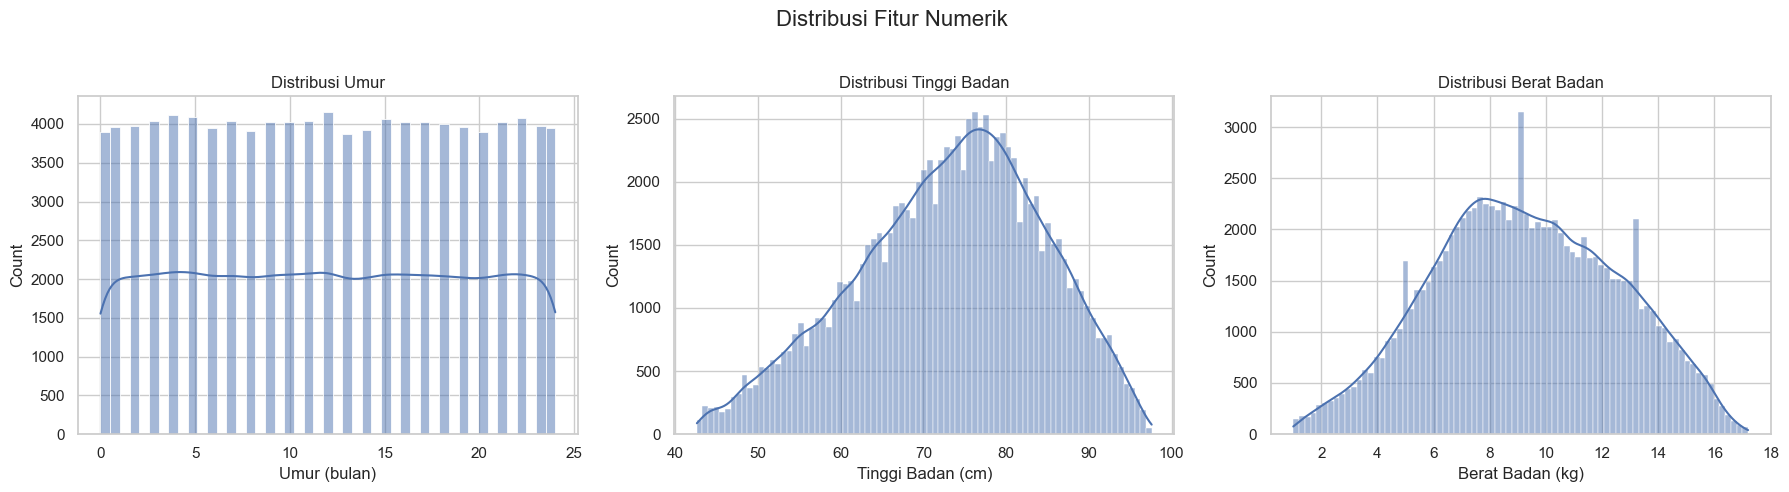

<Figure size 640x480 with 0 Axes>

In [12]:
# Distribusi Fitur Numerik (Umur, Tinggi, Berat)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribusi Fitur Numerik', fontsize=16)

sns.histplot(df['Umur (bulan)'], kde=True, ax=axes[0])
axes[0].set_title('Distribusi Umur')

sns.histplot(df['Tinggi Badan (cm)'], kde=True, ax=axes[1])
axes[1].set_title('Distribusi Tinggi Badan')

sns.histplot(df['Berat Badan (kg)'], kde=True, ax=axes[2])
axes[2].set_title('Distribusi Berat Badan')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
plt.clf() 

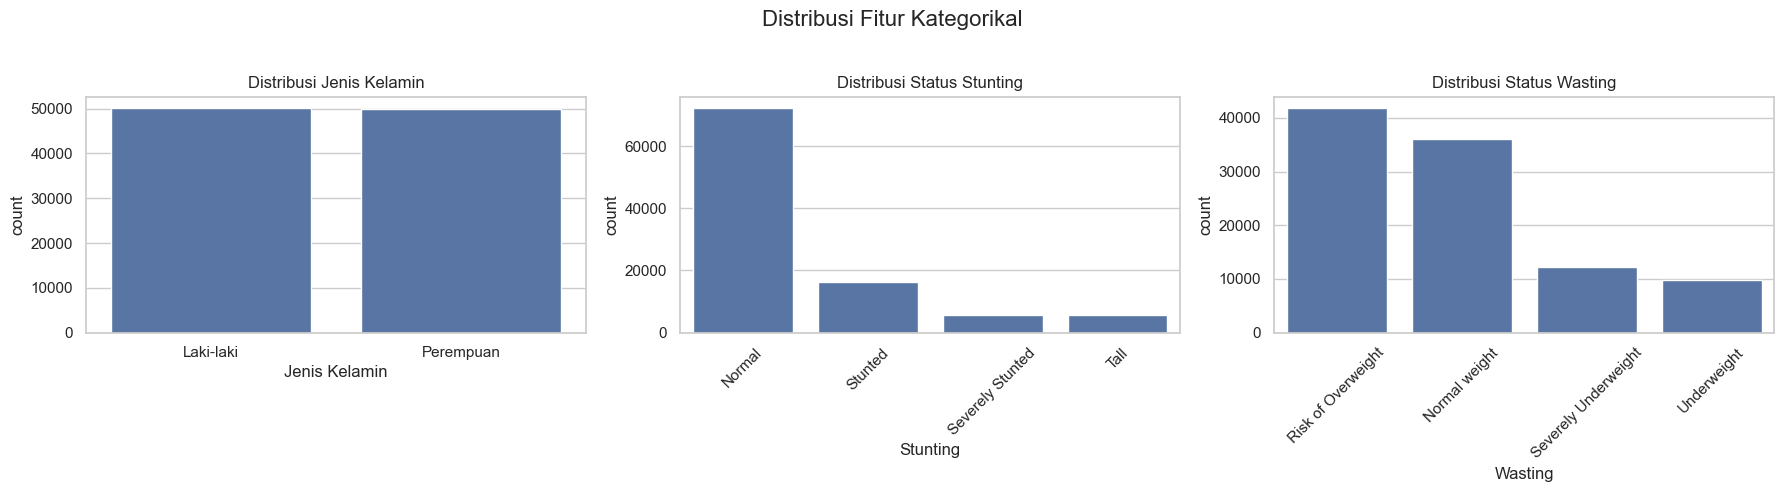

<Figure size 640x480 with 0 Axes>

In [13]:
# b. Distribusi Fitur Kategorikal (Jenis Kelamin, Stunting, Wasting)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribusi Fitur Kategorikal', fontsize=16)

sns.countplot(x='Jenis Kelamin', data=df, ax=axes[0], order=df['Jenis Kelamin'].value_counts().index)
axes[0].set_title('Distribusi Jenis Kelamin')

sns.countplot(x='Stunting', data=df, ax=axes[1], order=df['Stunting'].value_counts().index)
axes[1].set_title('Distribusi Status Stunting')
axes[1].tick_params(axis='x', rotation=45)

sns.countplot(x='Wasting', data=df, ax=axes[2], order=df['Wasting'].value_counts().index)
axes[2].set_title('Distribusi Status Wasting')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
plt.clf()

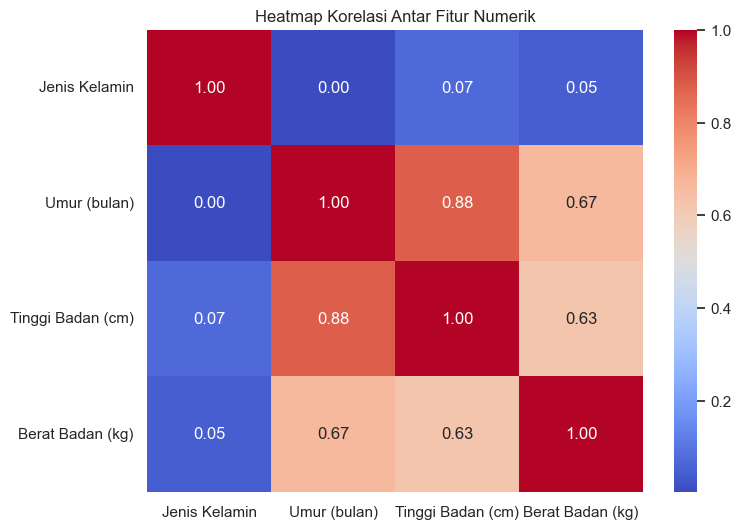

<Figure size 640x480 with 0 Axes>

In [14]:
# Korelasi antar fitur numerik
# Membuat salinan untuk analisis korelasi
df_corr = df.copy()

# Mengubah 'Jenis Kelamin' menjadi numerik untuk dimasukkan dalam heatmap
df_corr['Jenis Kelamin'] = df_corr['Jenis Kelamin'].apply(lambda x: 1 if x == 'Laki-laki' else 0)

# Pilih hanya kolom numerik untuk korelasi
numeric_cols = df_corr.select_dtypes(include=['number'])

plt.figure(figsize=(8, 6))
correlation_matrix = numeric_cols.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi Antar Fitur Numerik')
plt.show()
plt.clf()


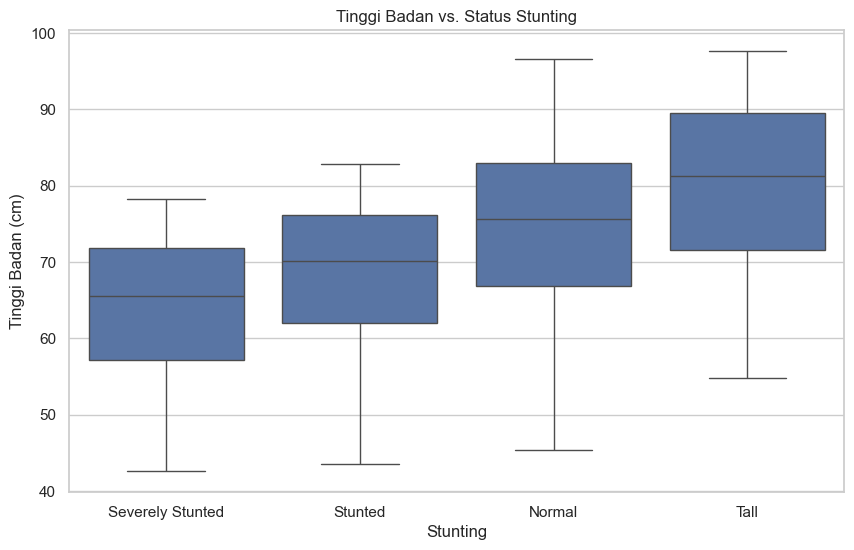

<Figure size 640x480 with 0 Axes>

In [15]:
# b. Hubungan antara Tinggi Badan dan Status Stunting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Stunting', y='Tinggi Badan (cm)', data=df, order=['Severely Stunted', 'Stunted', 'Normal', 'Tall'])
plt.title('Tinggi Badan vs. Status Stunting')
plt.show()
plt.clf()

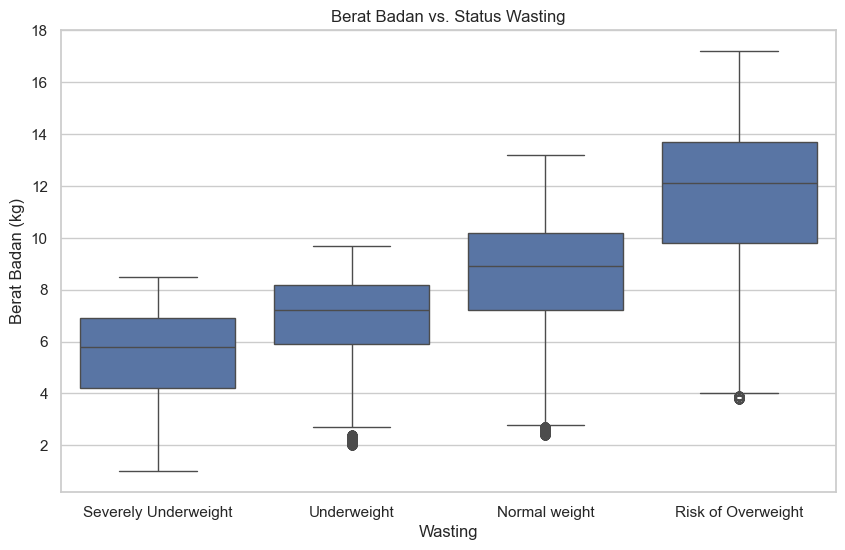

<Figure size 640x480 with 0 Axes>

In [16]:
# c. Hubungan antara Berat Badan dan Status Wasting
plt.figure(figsize=(10, 6))
sns.boxplot(x='Wasting', y='Berat Badan (kg)', data=df, order=['Severely Underweight', 'Underweight', 'Normal weight', 'Risk of Overweight'])
plt.title('Berat Badan vs. Status Wasting')
plt.show()
plt.clf()

In [17]:
# Encode
df['Jenis Kelamin'] = df['Jenis Kelamin'].apply(lambda x: 1 if x == 'Laki-laki' else 0)
le = LabelEncoder()
df['Stunting'] = le.fit_transform(df['Stunting'])

In [18]:
### ADDED: 1. Feature Engineering - Menambahkan Indeks Massa Tubuh (IMT)
# Mengubah tinggi badan ke meter untuk perhitungan IMT
df['IMT'] = df['Berat Badan (kg)'] / ((df['Tinggi Badan (cm)'] / 100) ** 2)

# Features & Target
### CHANGED: Menambahkan 'IMT' ke dalam fitur
X = df[['Jenis Kelamin', 'Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)', 'IMT']]
y = df['Stunting']

In [20]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [21]:
# Oversampling dengan SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [22]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Hyperparameter Grids (sama)
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1.0, 10, 100],
        'solver': ['liblinear', 'lbfgs', 'saga'],
        'penalty': ['l2']
    },
    "Decision Tree": {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'criterion': ['gini', 'entropy', 'log_loss']
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 9, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5],
        'bootstrap': [True, False]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2]
    }
}

# Tuning & Evaluasi
best_estimators = {}
results = {}

--- Tuning Model: Logistic Regression ---
Fitting 5 folds for each of 15 candidates, totalling 75 fits


d:\Data Projek\Projek(Stunting)\virtual\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 15 is smaller than n_iter=20. Running 15 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
d:\Data Projek\Projek(Stunting)\virtual\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Parameter terbaik: {'solver': 'liblinear', 'penalty': 'l2', 'C': 100}
Akurasi: 0.6299 | Balanced Acc: 0.7694
                  precision    recall  f1-score   support

          Normal       0.98      0.58      0.73     14462
Severely Stunted       0.38      0.89      0.53      1164
         Stunted       0.52      0.65      0.58      3232
            Tall       0.23      0.96      0.37      1142

        accuracy                           0.63     20000
       macro avg       0.53      0.77      0.55     20000
    weighted avg       0.83      0.63      0.67     20000



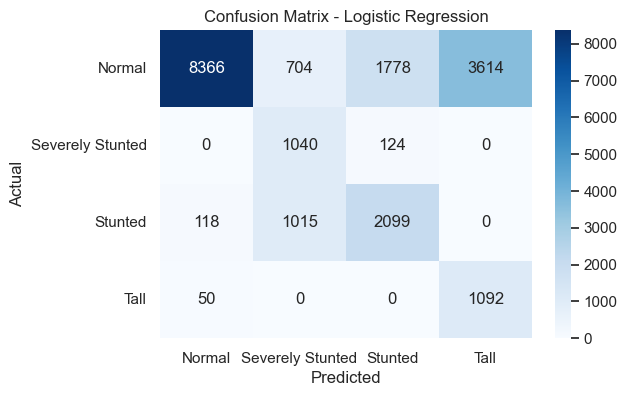

--- Tuning Model: Decision Tree ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Parameter terbaik: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
Akurasi: 0.9990 | Balanced Acc: 0.9982
                  precision    recall  f1-score   support

          Normal       1.00      1.00      1.00     14462
Severely Stunted       0.99      1.00      0.99      1164
         Stunted       1.00      0.99      1.00      3232
            Tall       1.00      1.00      1.00      1142

        accuracy                           1.00     20000
       macro avg       1.00      1.00      1.00     20000
    weighted avg       1.00      1.00      1.00     20000



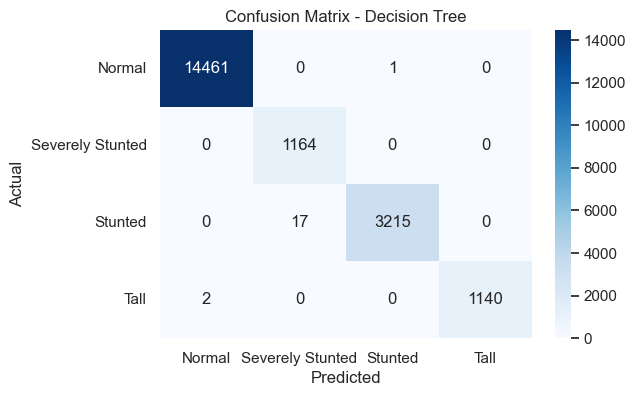

--- Tuning Model: KNN ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Parameter terbaik: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}
Akurasi: 0.9622 | Balanced Acc: 0.9510
                  precision    recall  f1-score   support

          Normal       0.99      0.97      0.98     14462
Severely Stunted       0.86      0.92      0.89      1164
         Stunted       0.92      0.93      0.93      3232
            Tall       0.82      0.98      0.89      1142

        accuracy                           0.96     20000
       macro avg       0.90      0.95      0.92     20000
    weighted avg       0.96      0.96      0.96     20000



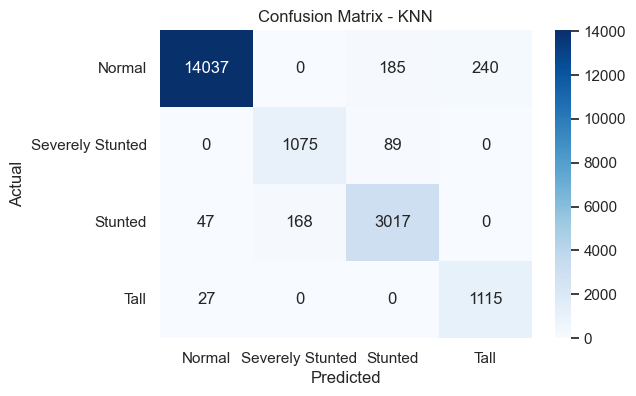

--- Tuning Model: Random Forest ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Parameter terbaik: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}
Akurasi: 0.9949 | Balanced Acc: 0.9889
                  precision    recall  f1-score   support

          Normal       1.00      1.00      1.00     14462
Severely Stunted       0.97      0.98      0.98      1164
         Stunted       0.99      0.99      0.99      3232
            Tall       1.00      0.99      0.99      1142

        accuracy                           0.99     20000
       macro avg       0.99      0.99      0.99     20000
    weighted avg       0.99      0.99      0.99     20000



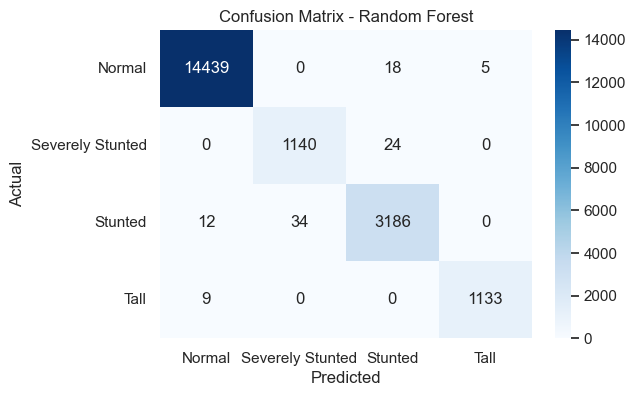

--- Tuning Model: XGBoost ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits


d:\Data Projek\Projek(Stunting)\virtual\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:18:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Parameter terbaik: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.8}
Akurasi: 0.9869 | Balanced Acc: 0.9799
                  precision    recall  f1-score   support

          Normal       1.00      0.99      0.99     14462
Severely Stunted       0.96      0.96      0.96      1164
         Stunted       0.97      0.98      0.97      3232
            Tall       0.94      0.99      0.96      1142

        accuracy                           0.99     20000
       macro avg       0.97      0.98      0.97     20000
    weighted avg       0.99      0.99      0.99     20000



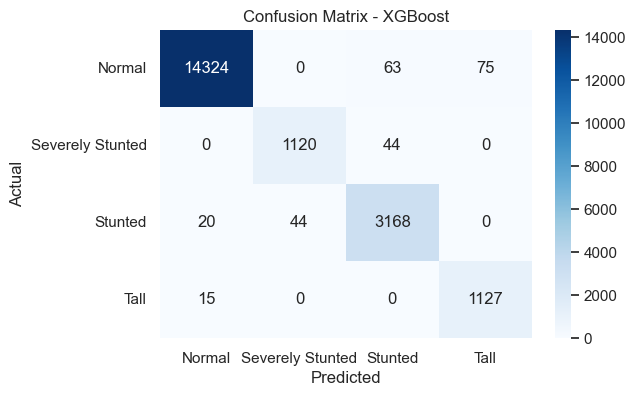

###################################################
##  Perbandingan Kinerja Model Setelah Peningkatan  ##
###################################################
                     Accuracy  Balanced Accuracy  Precision (macro avg)  \
Decision Tree         0.99900           0.998230               0.996289   
Random Forest         0.99490           0.988919               0.988046   
XGBoost               0.98695           0.979930               0.966174   
KNN                   0.96220           0.950997               0.899805   
Logistic Regression   0.62985           0.769403               0.528481   

                     Recall (macro avg)  F1-Score (macro avg)  \
Decision Tree                  0.998230              0.997245   
Random Forest                  0.988919              0.988477   
XGBoost                        0.979930              0.972880   
KNN                            0.950997              0.923468   
Logistic Regression            0.769403              0.552917   


In [24]:
for name in param_grids.keys():
    print(f"--- Tuning Model: {name} ---")
    
    ### CHANGED: 3. Menghapus class_weight='balanced' karena sudah ada SMOTE
    if name == "Logistic Regression":
        model = LogisticRegression(max_iter=1000, random_state=42)
    elif name == "Decision Tree":
        model = DecisionTreeClassifier(random_state=42)
    elif name == "KNN":
        model = KNeighborsClassifier()
    elif name == "Random Forest":
        model = RandomForestClassifier(random_state=42)
    elif name == "XGBoost":
        model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    else:
        continue

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=20,
        cv=5, ### CHANGED: Meningkatkan CV untuk evaluasi yang lebih robust
        n_jobs=-1,
        verbose=1,
        ### CHANGED: 2. Mengoptimalkan scoring metric
        scoring='balanced_accuracy',
        random_state=42
    )
    
    search.fit(X_train_scaled, y_train)
    print(f"Parameter terbaik: {search.best_params_}")
    best_estimators[name] = search.best_estimator_

    # Evaluasi
    best_model = best_estimators[name]
    y_pred = best_model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=[str(cls) for cls in le.classes_], output_dict=True)

    results[name] = {
        "Accuracy": accuracy,
        "Balanced Accuracy": balanced_acc,
        "Precision (macro avg)": report['macro avg']['precision'],
        "Recall (macro avg)": report['macro avg']['recall'],
        "F1-Score (macro avg)": report['macro avg']['f1-score'],
        "F1-Score (weighted avg)": report['weighted avg']['f1-score']
    }

    print(f"Akurasi: {accuracy:.4f} | Balanced Acc: {balanced_acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in le.classes_]))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Perbandingan hasil
results_df = pd.DataFrame(results).T.sort_values(by="Balanced Accuracy", ascending=False)
print("###################################################")
print("##  Perbandingan Kinerja Model Setelah Peningkatan  ##")
print("###################################################")
print(results_df)


In [33]:
import joblib

# Menyimpan model terbaik, scaler, dan label encoder
print("##      Menyimpan Model Terbaik untuk Prediksi     ##")

# 1. Mengidentifikasi model terbaik berdasarkan Balanced Accuracy
best_model_name = results_df.index[0]
best_model = best_estimators[best_model_name]

print(f"\nModel terbaik yang akan disimpan adalah: '{best_model_name}'")
print(f"Dengan Balanced Accuracy: {results_df.loc[best_model_name, 'Balanced Accuracy']:.4f}")

# 2. Menyimpan objek model, scaler, dan label encoder ke dalam file
joblib.dump(best_model, 'best_stunting_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(le, 'label_encoder.joblib')

print("\n✅ Model, scaler, dan label encoder berhasil disimpan!")
print("   - File model: best_stunting_model.joblib")
print("   - File scaler: scaler.joblib")
print("   - File encoder: label_encoder.joblib")

##      Menyimpan Model Terbaik untuk Prediksi     ##

Model terbaik yang akan disimpan adalah: 'Decision Tree'
Dengan Balanced Accuracy: 0.9982

✅ Model, scaler, dan label encoder berhasil disimpan!
   - File model: best_stunting_model.joblib
   - File scaler: scaler.joblib
   - File encoder: label_encoder.joblib


In [39]:
# --- CONTOH PENGGUNAAN MODEL YANG DISIMPAN UNTUK PREDIKSI ---

print("##      Contoh Prediksi Menggunakan Model Baru     ##")

# 1. Muat kembali model, scaler, dan encoder dari file yang disimpan
loaded_model = joblib.load('best_stunting_model.joblib')
loaded_scaler = joblib.load('scaler.joblib')
loaded_le = joblib.load('label_encoder.joblib')

print("\nModel, scaler, dan encoder berhasil dimuat kembali.\n")

# 2. Siapkan data baru (contoh kasus untuk diprediksi)
# Data harus dalam format DataFrame dengan nama kolom yang sama
jenis_kelamin_baru = 2  # 1 untuk Laki-laki
umur_bulan_baru = 28
tinggi_cm_baru = 100.0
berat_kg_baru = 15.0

# Jangan lupa hitung fitur turunan (IMT) juga!
tinggi_m_baru = tinggi_cm_baru / 100
imt_baru = berat_kg_baru / (tinggi_m_baru ** 2)

data_baru = pd.DataFrame({
    'Jenis Kelamin': [jenis_kelamin_baru],
    'Umur (bulan)': [umur_bulan_baru],
    'Tinggi Badan (cm)': [tinggi_cm_baru],
    'Berat Badan (kg)': [berat_kg_baru],
    'IMT': [imt_baru]
})

print("--- Data Baru yang Akan Diprediksi ---")
print(data_baru)

# 3. Lakukan scaling pada data baru menggunakan scaler yang sudah di-load
#    Gunakan .transform(), JANGAN .fit_transform()
data_baru_scaled = loaded_scaler.transform(data_baru)

# 4. Lakukan prediksi
prediksi_angka = loaded_model.predict(data_baru_scaled)
prediksi_probabilitas = loaded_model.predict_proba(data_baru_scaled)

# 5. Terjemahkan hasil prediksi ke label yang mudah dibaca
hasil_prediksi_label = loaded_le.inverse_transform(prediksi_angka)

print("\n--- Hasil Prediksi ---")
print(f"Hasil Prediksi (Label): {hasil_prediksi_label[0]}")

# Menampilkan probabilitas untuk memberikan konteks keyakinan model
print("\nKeyakinan Model (Probabilitas):")
for i, class_name in enumerate(loaded_le.classes_):
    print(f"   - Probabilitas '{class_name}': {prediksi_probabilitas[0][i] * 100:.2f}%")

##      Contoh Prediksi Menggunakan Model Baru     ##

Model, scaler, dan encoder berhasil dimuat kembali.

--- Data Baru yang Akan Diprediksi ---
   Jenis Kelamin  Umur (bulan)  Tinggi Badan (cm)  Berat Badan (kg)   IMT
0              2            28              100.0              15.0  15.0

--- Hasil Prediksi ---
Hasil Prediksi (Label): Tall

Keyakinan Model (Probabilitas):
   - Probabilitas 'Normal': 0.00%
   - Probabilitas 'Severely Stunted': 0.00%
   - Probabilitas 'Stunted': 0.00%
   - Probabilitas 'Tall': 100.00%
